In [1]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

from tqdm.notebook import tqdm_notebook as tqdm

import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(os.listdir("/content/drive/MyDrive/Dog Emotions Prediction"))

['images']


In [4]:
# angry = "/content/drive/MyDrive/Dog Emotions Prediction/images/angry"
root = "/content/drive/MyDrive/Dog Emotions Prediction/images"
angry = os.path.join(root , 'angry')
sad = os.path.join(root,'sad')
relaxed =  os.path.join(root,'relaxed')
happy = os.path.join(root,'happy')
# sad = "/content/drive/MyDrive/Dog Emotions Prediction/images/sad"
# relaxed = "/content/drive/MyDrive/Dog Emotions Prediction/images/relaxed"
# happy = "/content/drive/MyDrive/Dog Emotions Prediction/images/happy"

angry_path = os.listdir(angry)
sad_path = os.listdir(sad)
relaxed_path = os.listdir(relaxed)
happy_path = os.listdir(happy)

In [5]:
# Sample Images
def load_img(path):
  image = cv2.imread(path)
  image = cv2.resize(image,(224, 224))
  return image[...,::-1]

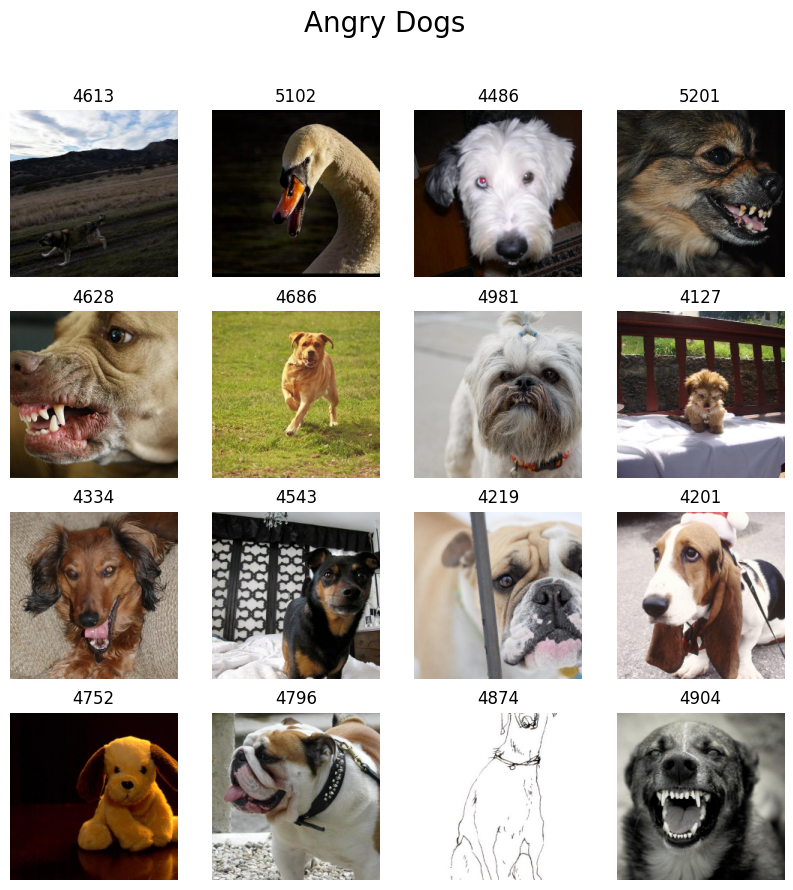

In [6]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(load_img(os.path.join(angry,angry_path[i])), cmap='gray')
  plt.suptitle("Angry Dogs", fontsize = 20)
  plt.title(angry_path[i][:4])
  plt.axis('off')

plt.show()

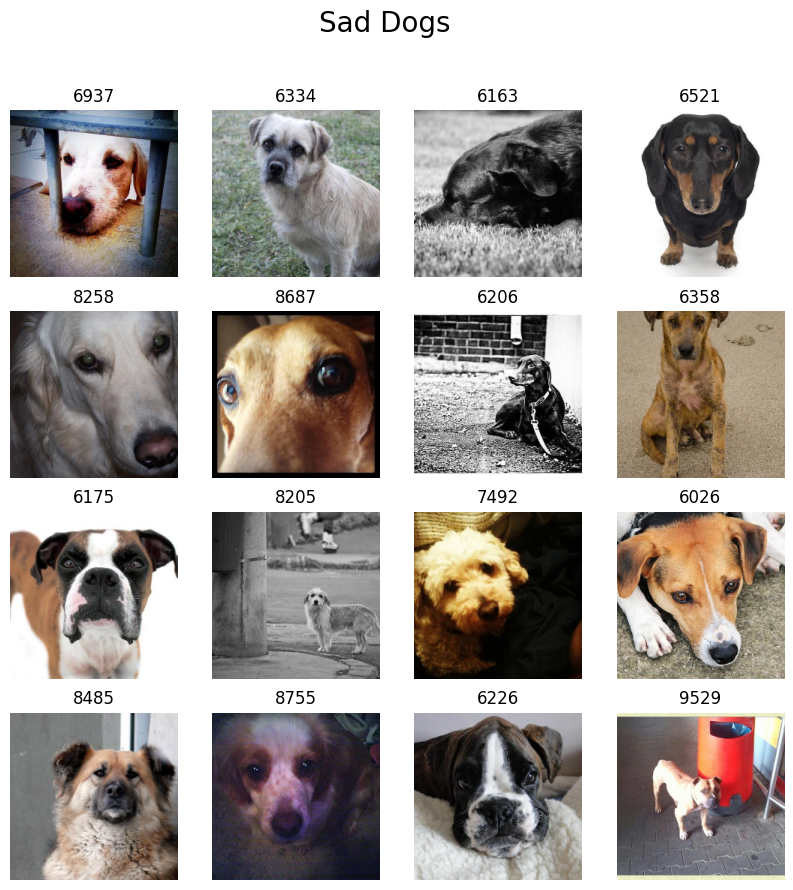

In [7]:
fig = plt.figure(figsize = (10,10))

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(load_img(os.path.join(sad,sad_path[i])), cmap='gray')
  plt.suptitle("Sad Dogs", fontsize = 20)
  plt.title(sad_path[i][:4])
  plt.axis('off')

plt.show()

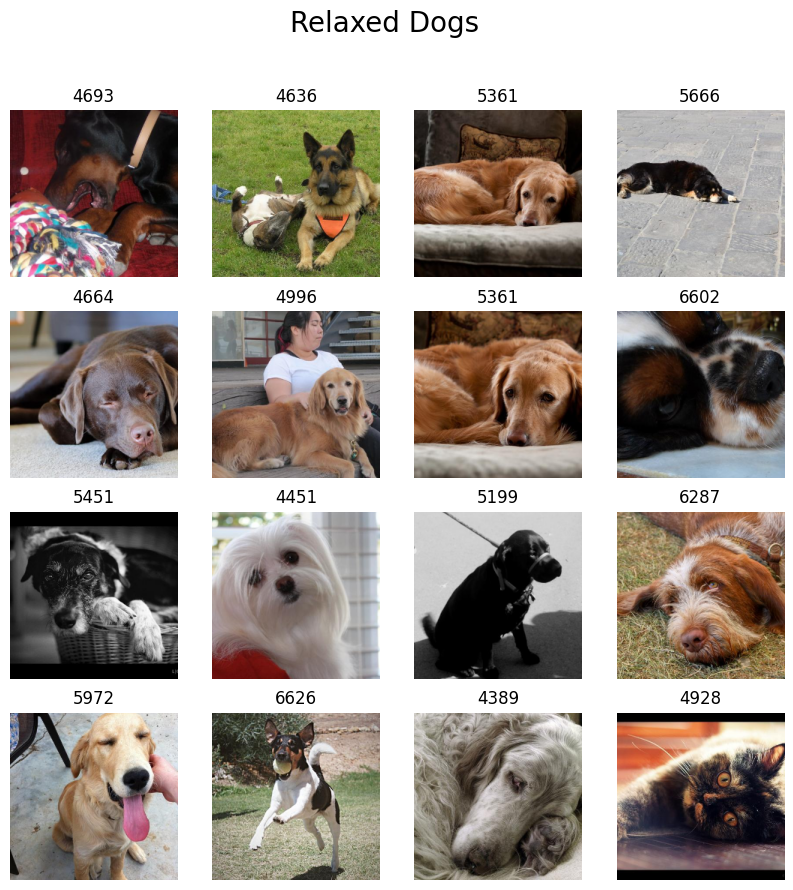

In [8]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(load_img(os.path.join(relaxed,relaxed_path[i])), cmap='gray')
  plt.suptitle("Relaxed Dogs", fontsize = 20)
  plt.title(relaxed_path[i][:4])
  plt.axis('off')

plt.show()

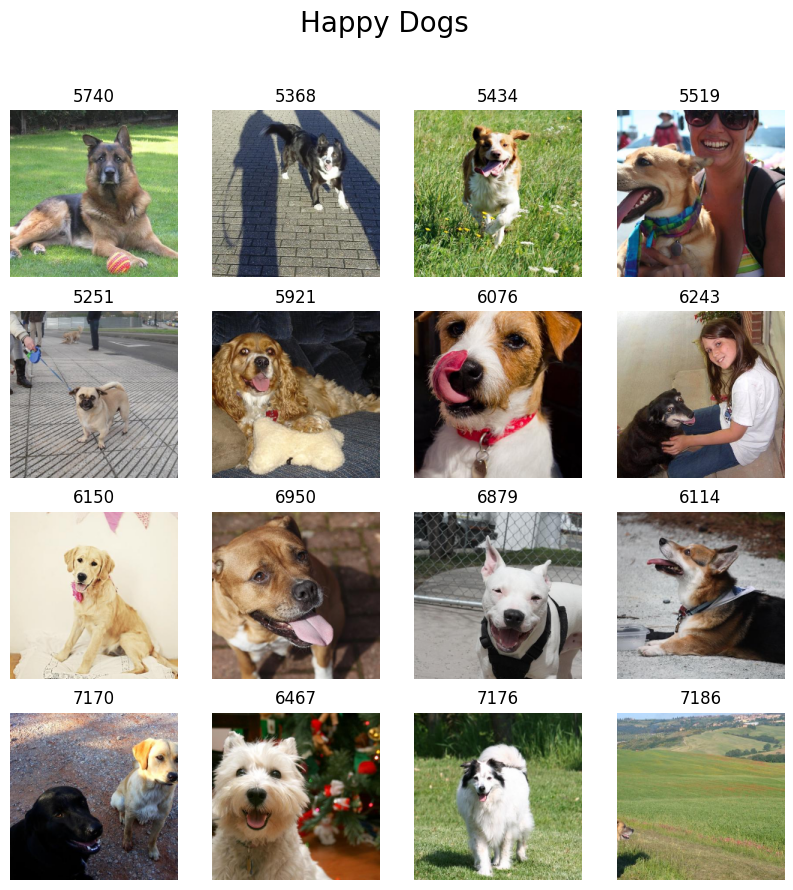

In [9]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(load_img(os.path.join(happy,happy_path[i])), cmap='gray')
  plt.suptitle("Happy Dogs", fontsize=20)
  plt.title(happy_path[i][:4])
  plt.axis('off')

plt.show()

In [10]:
# Modeling

dataset_path = "drive/MyDrive/Dog Emotions Prediction/images"

In [11]:

data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.3)

In [12]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="training")

Found 11147 images belonging to 4 classes.


In [13]:
val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="validation"
                                          )

Found 4774 images belonging to 4 classes.


VGG16

In [14]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(96,96,3))

9406464/9406464 [==============================] - 0s 0us/step


In [15]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    # Dense(32, activation = "relu"),
                    # Dropout(0.3),
                    Dense(4, activation = "sigmoid")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()
Model: "sequential"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [16]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
#hist = model.fit_generator(train,
 #                   epochs=20,
  #                  callbacks=[lr_callbacks],
   #                 validation_data=val)

<ipython-input-32-abeff273e3ad>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train,


Epoch 1/20
186/333 [===============>..............] - ETA: 29:10 - loss: 1.5021 - accuracy: 0.4029

In [17]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="training")

val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="validation"
                                          )

Found 11147 images belonging to 4 classes.
Found 4774 images belonging to 4 classes.


In [18]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [19]:
vgg16_model.output[-1]

<KerasTensor: shape=(7, 7, 512) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [20]:
# model = Sequential()
# for layer in vgg16_model.layers[:-1]:
#     model.add(layer)

# for layer in model.layers:
#     layer.trainable = False

# model.add(Dense(2, activation='softmax'))


model = Sequential([vgg16_model,
                    Flatten(),
#                     GlobalAveragePooling2D(),
#                     Dense(512, activation = "relu"),
#                     BatchNormalization(),
#                     Dropout(0.3),
#                     Dense(128, activation = "relu"),
#                     Dropout(0.1),
#                     # Dense(32, activation = "relu"),
#                     # Dropout(0.3),
                    Dense(4, activation = "sigmoid")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 14815044 (56.51 MB)
Trainable params: 100356 (392.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [21]:
hist =  model.fit(train,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val)

Epoch 1/20
114/114 [==============================] - 2554s 22s/step - loss: 1.3400 - accuracy: 0.4336 - val_loss: 1.3462 - val_accuracy: 0.4495 - lr: 0.0010
Epoch 2/20
114/114 [==============================] - 64s 565ms/step - loss: 1.1777 - accuracy: 0.5074 - val_loss: 1.3568 - val_accuracy: 0.4393 - lr: 0.0010
Epoch 3/20
114/114 [==============================] - 67s 584ms/step - loss: 1.0350 - accuracy: 0.5750 - val_loss: 1.3759 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 4/20
114/114 [==============================] - 69s 603ms/step - loss: 0.8766 - accuracy: 0.6601 - val_loss: 1.2468 - val_accuracy: 0.4728 - lr: 1.0000e-04
Epoch 5/20
114/114 [==============================] - 69s 603ms/step - loss: 0.8571 - accuracy: 0.6689 - val_loss: 1.2541 - val_accuracy: 0.4719 - lr: 1.0000e-04
Epoch 6/20
114/114 [==============================] - 69s 608ms/step - loss: 0.8383 - accuracy: 0.6845 - val_loss: 1.2333 - val_accuracy: 0.4824 - lr: 1.0000e-04
Epoch 7/20
114/114 [====================

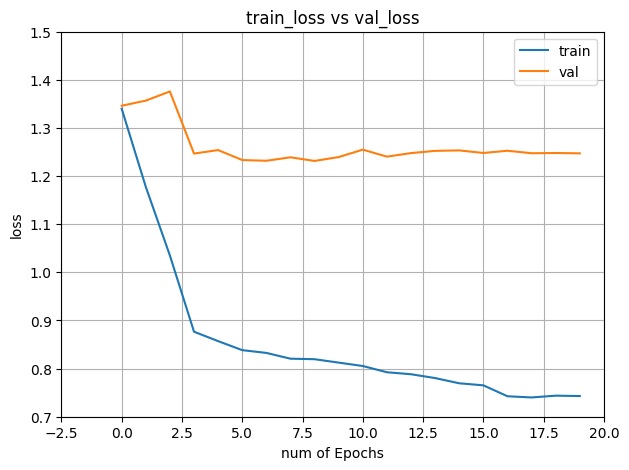

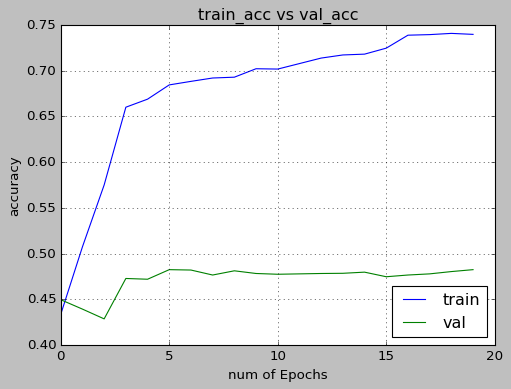

In [22]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [23]:
#Creating an array of predicted test images

predictions = model.predict_generator(val)

<ipython-input-23-a5c5724c89c6>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(val)


In [26]:
print(val_path+val.filenames[start_index+i])

/content/drive/MyDrive/Dog Emotions Prediction/imagesangry/15724596034_2488d3b6db_b.jpg


In [25]:
val_path = "/content/drive/MyDrive/Dog Emotions Prediction/images"

plt.figure(figsize=(15,15))

start_index = 250

for i in range(16):
  plt.subplot(4,4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  preds = np.argmax(predictions[[start_index+i]])

  gt = val.filenames[start_index+i][9:13]


  if gt == "angry":
    gt = 0
  elif gt == 'sad':
    gt = 1
  elif gt == 'pleased':
    gt = 2
  else:
    gt = 3

  if preds != gt:
    col ="r"
  else:
    col = "g"

  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
  plt.imshow(load_img(os.path.join(val_path, val.filenames[start_index+i])))
  plt.tight_layout()

plt.show()

Output hidden; open in https://colab.research.google.com to view.